# **Connect with Google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import basic libraries**

In [ ]:
# Standard data science libraries
import psutil
import humanize
import os
from IPython.display import display_html

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


# **Set Google Drive path of dataset folder**

In [ ]:
dataDirectory= "drive/My Drive/data"
print(os.listdir(dataDirectory))

['osteoporosis', 'osteopenia', 'normal']


# **Install Dependencies**

In [ ]:
#pip install numpy opencv-python pillow tensorflow keras imutils scikit-learn matplotlib

# **Import Libraries**

In [ ]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline
import tensorflow as tf

# **Plot Sample Images**

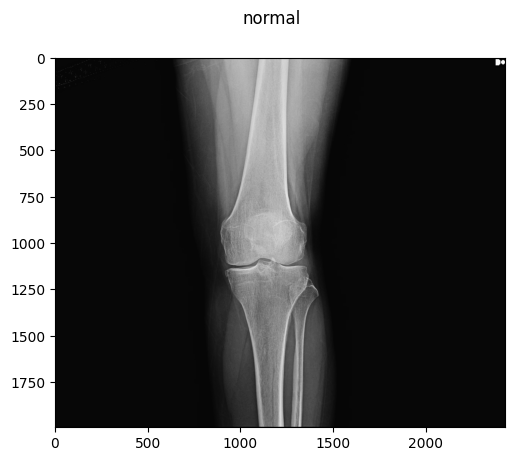

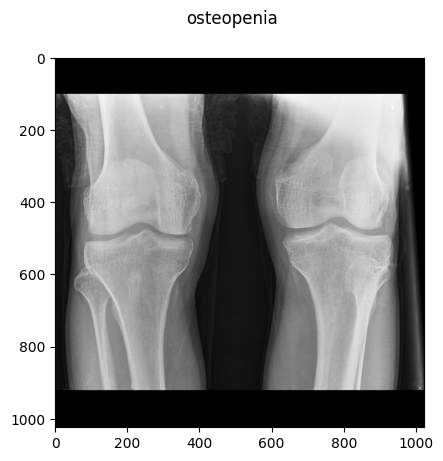

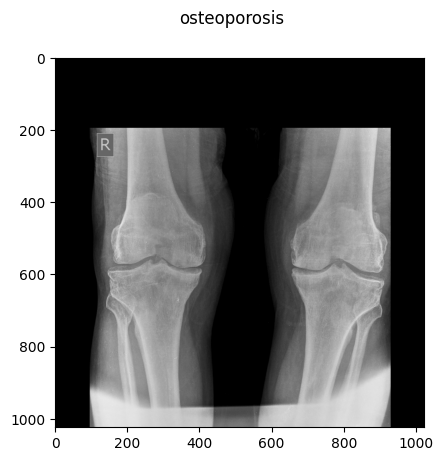

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

normal_images = []
for img_path in glob.glob(dataDirectory + '/normal/*'):
    normal_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('normal')
plt.imshow(normal_images[0], cmap='gray')

osteopenia_images = []
for img_path in glob.glob(dataDirectory + '/osteopenia/*'):
    osteopenia_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('osteopenia')
plt.imshow(osteopenia_images[0], cmap='gray')

osteoporosis_images = []
for img_path in glob.glob(dataDirectory + '/osteoporosis/*'):
    osteoporosis_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('osteoporosis')
plt.imshow(osteoporosis_images[0], cmap='gray')

# **Caluclate total images in each class**

In [ ]:
print(len(normal_images))
print(len(osteopenia_images))
print(len( osteoporosis_images))

36
154
49


In [ ]:
IMG_W = 150
IMG_H = 150
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 3
EPOCHS = 3
batchSize = 6
BATCH_SIZE = 6

# **Data generators**


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    dataDirectory,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
   dataDirectory,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle= False,
    subset='validation')

Found 169 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


# **Load data from directory**

In [ ]:
selectedClasses = ['normal', 'osteopenia','osteoporosis']

In [ ]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(train_generator.classes).count(cls))
print ("")

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(validation_generator.classes).count(cls))
print ("")

In train_generator 
normal :	 26
osteopenia :	 108
osteoporosis :	 35

In validation_generator 
normal :	 10
osteopenia :	 46
osteoporosis :	 14



# **Auxilary Functions for ploting images**

In [ ]:
#plots images with labels within jupyter notebook
def plots(ims, figsize = (22,22), rows=4, interp=False, titles=None, maxNum = 9):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))

    f = plt.figure(figsize=figsize)
    #cols = len(ims) //rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    #for i in range(len(ims)):
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=20)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

# **Create model by Transfer Learning from InceptionV3**

In [ ]:
#InceptionV3

base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
base_model.trainable = False

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
# and a sofymax/logistic layer -- we have 3 classes
predictions = Dense(len(selectedClasses), activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


model.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['input_7[0][0]']                
 D)                             3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_6[0][0]']       
                             

# **Model Checkpoint**

In [ ]:
modelName= "InceptionTutorial"
#save the best weights over the same file with the model name

#filepath="checkpoints/"+modelName+"_bestweights.hdf5"
filepath=modelName+"_bestweights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# **Compile the model**

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# **Train the model**

In [ ]:
stepsPerEpoch= (train_generator.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(validation_generator.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps)

stepsPerEpoch:  29
validationSteps:  12


In [ ]:
train_generator.reset()
validation_generator.reset()

# Fit the model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 25,
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/25
29/29 [==============================] - ETA: 0s - loss: 1.4835 - accuracy: 0.5325
Epoch 1: val_accuracy improved from -inf to 0.38571, saving model to InceptionTutorial_bestweights.hdf5
29/29 [==============================] - 35s 892ms/step - loss: 1.4835 - accuracy: 0.5325 - val_loss: 1.5035 - val_accuracy: 0.3857
Epoch 2/25
29/29 [==============================] - ETA: 0s - loss: 1.2463 - accuracy: 0.5917
Epoch 2: val_accuracy did not improve from 0.38571
29/29 [==============================] - 22s 765ms/step - loss: 1.2463 - accuracy: 0.5917 - val_loss: 1.9067 - val_accuracy: 0.3286
Epoch 3/25
29/29 [==============================] - ETA: 0s - loss: 1.1803 - accuracy: 0.5562
Epoch 3: val_accuracy improved from 0.38571 to 0.60000, saving model to InceptionTutorial_bestweights.hdf5
29/29 [==============================] - 26s 914ms/step - loss: 1.1803 - accuracy: 0.5562 - val_loss: 2.0955 - val_accuracy: 0.6000
Epoch 4/25
29/29 [==============================] - ETA: 0s 

# **Show Training History**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


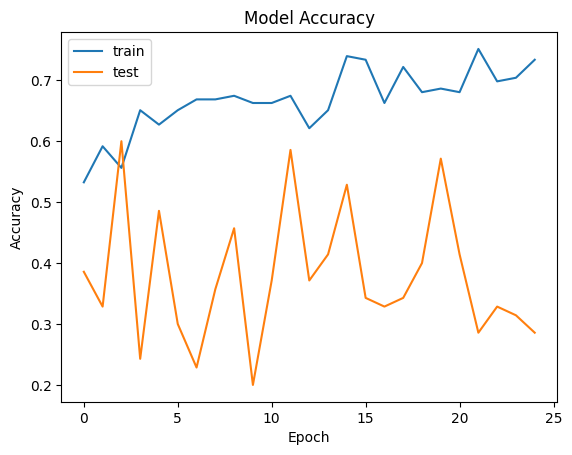

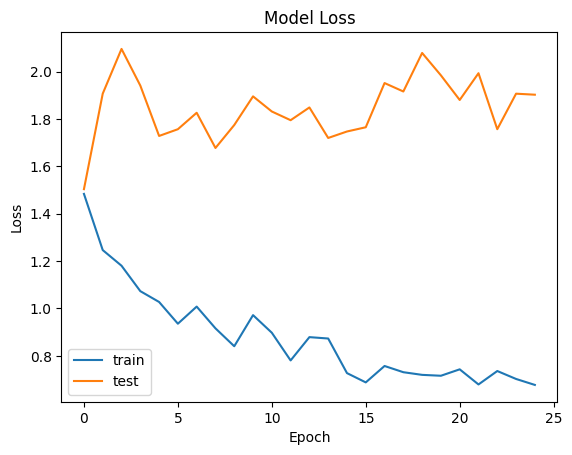

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# **Save the model and last weights**

In [ ]:
timestr = time.strftime("%Y%m%d_%H%M%S")

# serialize model to JSON
model_json = model.to_json()
with open(timestr+"_"+modelName+"_MODEL_3"+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(timestr+"_"+modelName+"_3_LAST_WEIGHTS_"+".h5")

# **Evaulate the model**

In [ ]:
validation_generator.reset()
score = model.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)
print("For validation data set; Loss: ",score[0]," Accuracy: ", score[1])

<ipython-input-27-217da5d4d1b4>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)


For validation data set; Loss:  1.9007699489593506  Accuracy:  0.2571428716182709


# **Make Predictions**

In [ ]:
validation_generator.reset()
testStep = (validation_generator.samples + (batchSize-1)) // batchSize
print("testStep: ", testStep)
predictions = model.predict_generator(validation_generator, steps = testStep ,  verbose = 1)
len(predictions)

testStep:  12


<ipython-input-28-a39ce7f49f0e>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(validation_generator, steps = testStep ,  verbose = 1)


12/12 [==============================] - 9s 520ms/step


70

In [ ]:
len(predictions)

70

# **Decode Labels**

In [ ]:
predicted_class_indices=np.argmax(predictions,axis=1)
print(predicted_class_indices)
len(predicted_class_indices)

[1 1 1 1 1 1 1 1 1 0 1 1 0 0 2 1 2 2 1 1 0 1 1 1 2 0 2 1 0 0 1 1 0 1 2 2 0
 0 0 1 2 2 2 1 1 1 0 0 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


70

In [ ]:
labels = (validation_generator.class_indices)
print(labels)

{'normal': 0, 'osteopenia': 1, 'osteoporosis': 2}


In [ ]:
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'normal', 1: 'osteopenia', 2: 'osteoporosis'}


In [ ]:
predictedLables= [labels[k] for k in predicted_class_indices]
print(predictedLables)
len(predictedLables)

['osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'normal', 'osteopenia', 'osteopenia', 'normal', 'normal', 'osteoporosis', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteopenia', 'osteopenia', 'normal', 'osteopenia', 'osteopenia', 'osteopenia', 'osteoporosis', 'normal', 'osteoporosis', 'osteopenia', 'normal', 'normal', 'osteopenia', 'osteopenia', 'normal', 'osteopenia', 'osteoporosis', 'osteoporosis', 'normal', 'normal', 'normal', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteopenia', 'osteopenia', 'osteopenia', 'normal', 'normal', 'osteopenia', 'normal', 'normal', 'osteoporosis', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia']


70

In [ ]:
actualLables= [labels[k] for k in validation_generator.classes]
print(actualLables)
len(actualLables)

['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteopenia', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis']


70

# **Accuracy**

In [ ]:
accuracy_score(actualLables, predictedLables)

0.3142857142857143

# **Evaluation metrics based on a confusion matrix**

In [ ]:
matrix = confusion_matrix(actualLables, predictedLables)
print(labels)
matrix

{0: 'normal', 1: 'osteopenia', 2: 'osteoporosis'}


array([[ 1,  9,  0],
       [14, 21, 11],
       [ 0, 14,  0]])

# **The precision and recall metrics**

In [ ]:
print(classification_report(actualLables, predictedLables))

              precision    recall  f1-score   support

      normal       0.07      0.10      0.08        10
  osteopenia       0.48      0.46      0.47        46
osteoporosis       0.00      0.00      0.00        14

    accuracy                           0.31        70
   macro avg       0.18      0.19      0.18        70
weighted avg       0.32      0.31      0.32        70



In [ ]:
recall_score( actualLables, predictedLables,average='weighted')

0.3142857142857143

In [ ]:
precision_score( actualLables, predictedLables,average='weighted')

0.3231601731601732


## **Plot the confusion matrix**

In [ ]:
#Prepared code that is taken from SKLearn Website, Creates Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 1  9  0]
 [14 21 11]
 [ 0 14  0]]


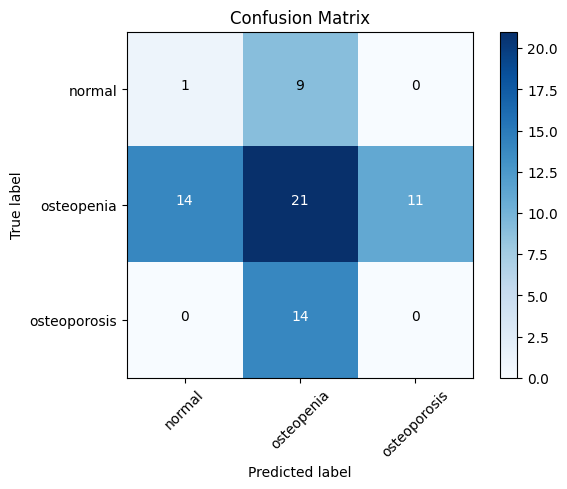

In [ ]:
cm_plot_labels = selectedClasses
plot_confusion_matrix(matrix,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix')

# **Save Predictions**

In [ ]:
filenames=validation_generator.filenames
directory= validation_generator.directory
results=pd.DataFrame({"Directory":directory,
                      "Filename":filenames,
                      "Predictions":predictedLables,
                     "Actuals": actualLables })
results.to_csv("results.csv",index=False)

# **Show some sample predictions with corresponding true**

In [ ]:
#import glob
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

res = results[260:280]

images = []
#for img_path in glob.glob('images/*.jpg'):
for img_path in "./"+res['Directory']+"/"+res['Filename']:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(80,80))
columns = 4
for i, image in enumerate(images):
    ax= plt.subplot(len(images) / columns + 1, columns, i + 1)
    ax.set_title(res['Actuals'].iloc[i]+" "+res['Predictions'].iloc[i], fontsize=40)
    plt.imshow(image)

<Figure size 8000x8000 with 0 Axes>